# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,614714,32.9,1321371,70.6,1321371,70.6
Vcells,1093576,8.4,8388608,64.0,1632151,12.5


Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 4.2.3"
Loading required package: DiceKriging

Warning message:
"package 'DiceKriging' was built under R version 4.2.3"
Loading required package: mlrMBO

Warning message:
"package 'mlrMBO' was built under R version 4.2.3"
Loading required package: mlr

Warning message:
"package 'mlr' was built under R version 4.2.3"
Loading required package: ParamHelpers

Warning message:
"package 'ParamHelpers' was built under R version 4.2.3"
Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Warning message:
"package 'smoof' was built under R version 4.2.3"
Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package

### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

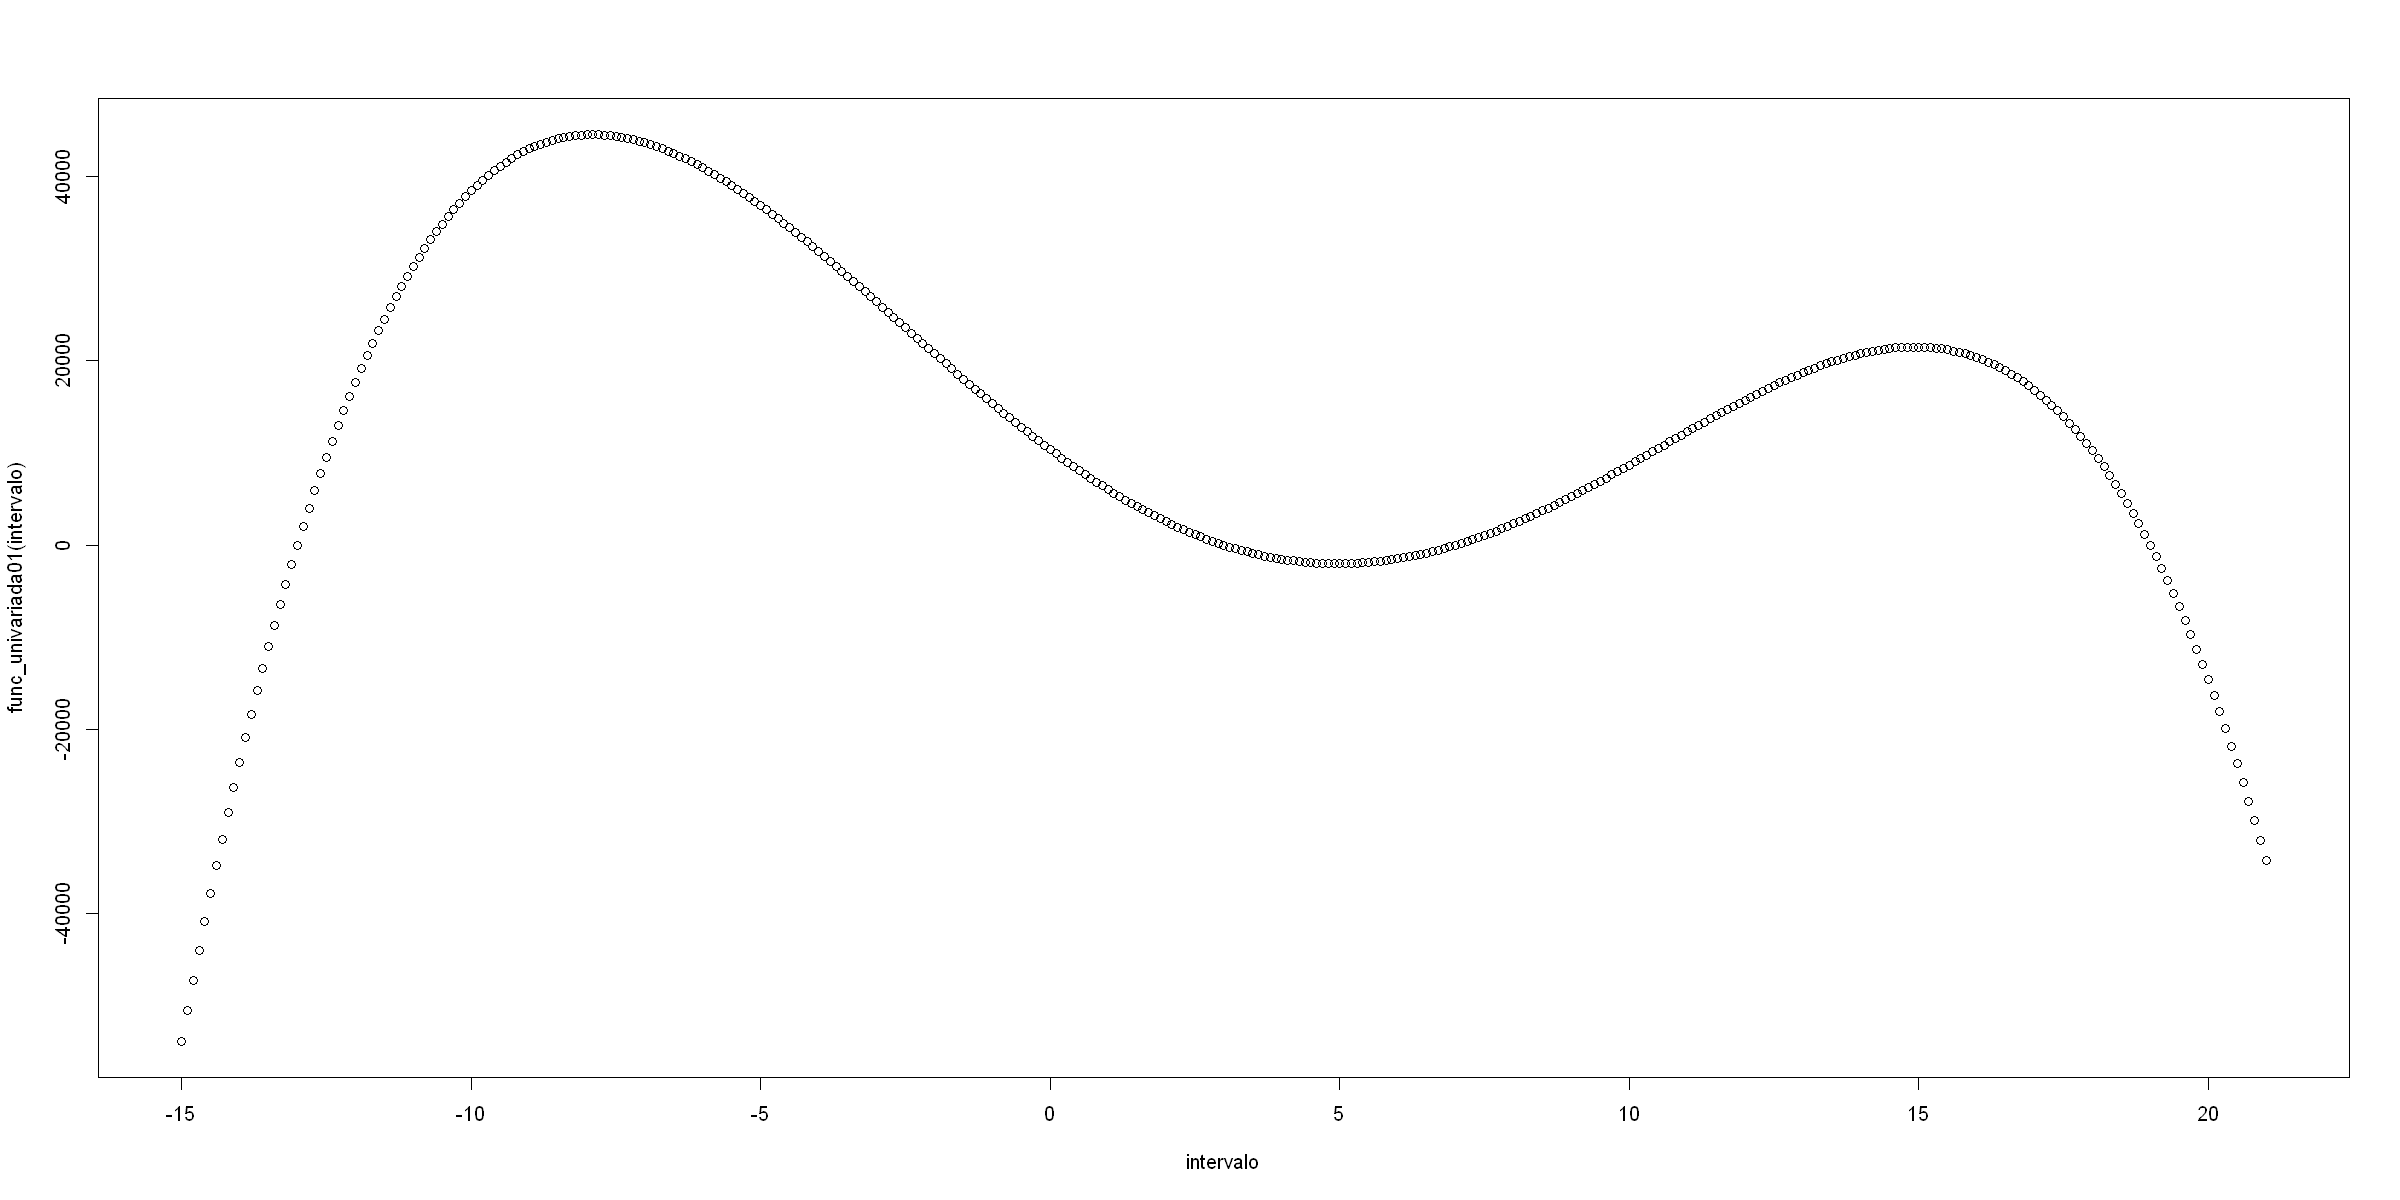

In [3]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [4]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [5]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [6]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [7]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=-61.8 : y = -3.51e+07 : 0.0 secs : initdesign

[mbo] 0: x=31 : y = -7.04e+05 : 0.0 secs : initdesign

[mbo] 0: x=67.8 : y = -3.11e+07 : 0.0 secs : initdesign

[mbo] 0: x=-13.4 : y = -9.76e+03 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -72.20487 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       72.205  |proj g|=     0.014127
At iterate     1  f =       72.205  |proj g|=      0.014114
At iterate     2  f =       72.133  |proj g|=    4.6878e-29
Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Derivative >= 0, backtracking line search impossible.final  value 72.133121 
stopped after 2 iterations


[mbo] 1: x=-14 : y = -2.42e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -86.69558 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       86.696  |proj g|=    0.0076285
At iterate     1  f =       86.696  |proj g|=     0.0076235
At iterate     2  f =       86.671  |proj g|=     0.0055387
At iterate     3  f =       86.663  |proj g|=     0.0016212
At iterate     4  f =       86.662  |proj g|=     0.0002544
At iterate     5  f =       86.662  |proj g|=    1.4739e-05
At iterate     6  f =       86.662  |proj g|=     1.243e-07

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 2: x=13.2 : y = 1.91e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -103.4281 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       103.43  |proj g|=    0.0047023
At iterate     1  f =       103.43  |proj g|=     0.0047002
At iterate     2  f =       103.41  |proj g|=     0.0024496
At iterate     3  f =       103.41  |proj g|=    0.00065989
At iterate     4  f =       103.41  |proj g|=    6.9936e-05
At iterate     5  f =       103.41  |proj g|=    2.3096e-06
At iterate     6  f =       103.41  |proj g|=    7.7546e-09

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 3: x=22.4 : y = -7.19e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -118.8727 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       118.87  |proj g|=    0.0038863
At iterate     1  f =       118.87  |proj g|=     0.0038855
At iterate     2  f =       118.85  |proj g|=     0.0030668
At iterate     3  f =       118.84  |proj g|=    0.00092749
At iterate     4  f =       118.84  |proj g|=    0.00016592
At iterate     5  f =       118.84  |proj g|=    1.1622e-05
At iterate     6  f =       118.84  |proj g|=    1.3359e-07

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 4: x=0.632 : y = 7.55e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -134.2129 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       134.21  |proj g|=    1.371e-06
At iterate     1  f =       134.21  |proj g|=    1.3707e-06

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.37069e-06
final function value 134.213

F = 134.213
final  value 134.212935 
converged


[mbo] 5: x=-5.86 : y = 4.05e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -148.5204 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       148.52  |proj g|=   0.00025776
At iterate     1  f =       148.52  |proj g|=    0.00025772

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000257721
final function value 148.52

F = 148.52
final  value 148.520448 
converged


[mbo] 6: x=7.13 : y = 261 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -162.6147 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       162.61  |proj g|=   0.00077188
At iterate     1  f =       162.61  |proj g|=    0.00077178
At iterate     2  f =       162.61  |proj g|=    6.4722e-05
At iterate     3  f =       162.61  |proj g|=    6.0131e-06
At iterate     4  f =       162.61  |proj g|=    5.2888e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 5.28877e-08
final function value 162.612

F = 162.612
final  value 162.612155 
conver

[mbo] 7: x=17.4 : y = 1.43e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -176.1854 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       176.19  |proj g|=   9.4276e-05
At iterate     1  f =       176.19  |proj g|=    9.4269e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 9.42694e-05
final function value 176.185

F = 176.185
final  value 176.185377 
converged


[mbo] 8: x=-9.17 : y = 4.25e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -189.2432 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       189.24  |proj g|=   3.7457e-05
At iterate     1  f =       189.24  |proj g|=    3.7455e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.74551e-05
final function value 189.243

F = 189.243
final  value 189.243232 
converged


[mbo] 9: x=-2.71 : y = 2.48e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -202.1059 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       202.11  |proj g|=   0.00063433
At iterate     1  f =       202.11  |proj g|=    0.00063429

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000634293
final function value 202.106

F = 202.106
final  value 202.105918 
converged


[mbo] 10: x=3.94 : y = -1.46e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -214.8966 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        214.9  |proj g|=   0.00035186
At iterate     1  f =        214.9  |proj g|=    0.00035185

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000351853
final function value 214.897

F = 214.897
final  value 214.896597 
converged


[mbo] 11: x=10.3 : y = 9.75e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -227.499 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        227.5  |proj g|=   1.0948e-05
At iterate     1  f =        227.5  |proj g|=    1.0948e-05

iterations 1
function evaluations 7
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.0948e-05
final function value 227.499

F = 227.499
final  value 227.498969 
converged


[mbo] 12: x=26 : y = -2.36e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -240.7925 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       240.79  |proj g|=    0.0010072
At iterate     1  f =       240.79  |proj g|=     0.0010072
At iterate     2  f =       240.78  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 240.781

F = 240.781
final  value 240.781312 
converged


[mbo] 13: x=-7.56 : y = 4.44e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -252.5117 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       252.51  |proj g|=    0.0012478
At iterate     1  f =       252.51  |proj g|=     0.0012478
At iterate     2  f =       252.51  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 252.507

F = 252.507
final  value 252.507407 
converged


[mbo] 14: x=15.3 : y = 2.14e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -264.5757 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       264.58  |proj g|=    0.0020985
At iterate     1  f =       264.58  |proj g|=     0.0020984
At iterate     2  f =       264.56  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 264.562

F = 264.562
final  value 264.562198 
converged


[mbo] 15: x=-10.9 : y = 3.15e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -276.4036 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        276.4  |proj g|=    0.0032348
At iterate     1  f =        276.4  |proj g|=     0.0032346
At iterate     2  f =       276.36  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 276.363

F = 276.363
final  value 276.362511 
converged


[mbo] 16: x=-4.38 : y = 3.38e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -287.9089 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       287.91  |proj g|=    0.0038301
At iterate     1  f =       287.91  |proj g|=     0.0038299
At iterate     2  f =       287.87  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 287.868

F = 287.868
final  value 287.867607 
converged


[mbo] 17: x=19.6 : y = -8.02e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -300.129 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       300.13  |proj g|=    0.0063685
At iterate     1  f =       300.13  |proj g|=     0.0063679
At iterate     2  f =       299.96  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 299.959

F = 299.959
final  value 299.958817 
converged


[mbo] 18: x=-1.11 : y = 1.59e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -311.4985 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        311.5  |proj g|=    0.0045966
At iterate     1  f =        311.5  |proj g|=     0.0045963
At iterate     2  f =       311.49  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 311.492

F = 311.492
final  value 311.491720 
converged


[mbo] 19: x=-8.34 : y = 4.43e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -321.9914 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       321.99  |proj g|=    0.0052837
At iterate     1  f =       321.99  |proj g|=     0.0052834
At iterate     2  f =       321.98  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 321.984

F = 321.984
final  value 321.983599 
converged


[mbo] 20: x=-6.75 : y = 4.31e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -332.451 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       332.45  |proj g|=     0.005953
At iterate     1  f =       332.45  |proj g|=     0.0059525
At iterate     2  f =       332.44  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 332.444

F = 332.444
final  value 332.443632 
converged


[mbo] 21: x=-9.94 : y = 3.88e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -342.9458 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       342.95  |proj g|=    0.0069893
At iterate     1  f =       342.95  |proj g|=     0.0069887
At iterate     2  f =       342.91  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 342.909

F = 342.909
final  value 342.908773 
converged


[mbo] 22: x=11.8 : y = 1.5e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -354.2697 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       354.27  |proj g|=    0.0083971
At iterate     1  f =       354.27  |proj g|=     0.0083963
At iterate     2  f =       354.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 354.17

F = 354.17
final  value 354.169742 
converged


[mbo] 23: x=2.28 : y = 1.74e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -365.6244 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       365.62  |proj g|=    0.0082865
At iterate     1  f =       365.62  |proj g|=     0.0082858
At iterate     2  f =       365.59  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 365.59

F = 365.59
final  value 365.590247 
converged


[mbo] 24: x=8.72 : y = 4.41e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -376.9251 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       376.93  |proj g|=    0.0086742
At iterate     1  f =       376.93  |proj g|=     0.0086734
At iterate     2  f =       376.92  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 376.916

F = 376.916
final  value 376.916347 
converged


[mbo] 25: x=-7.95 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  259.1497 
  - best initial criterion value(s) :  -386.3223 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       386.32  |proj g|=     0.010609
At iterate     1  f =       386.32  |proj g|=      0.010608
At iterate     2  f =        386.2  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 386.199

F = 386.199
final  value 386.198616 
converged


In [8]:
tb_resultados  <- as.data.table( run$opt.path )

In [9]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-61.7574856,-3.506421e+07,0,NA,NA,0.01,NA,NA,NA,initdesign,NA,NA,NA
30.9559641,-7.039155e+05,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
67.8173529,-3.110482e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-13.4471783,-9.759160e+03,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-14.0233527,-2.418931e+04,1,NA,NA,0.00,-2596849.049,NA,0.01,infill_ei,0.18,12053106.804,-5367986.5701
13.1512317,1.910150e+04,2,NA,NA,0.00,-3823211.927,NA,0.02,infill_ei,0.15,8896560.955,525397.4326
22.3988194,-7.188025e+04,3,NA,NA,0.00,-1255426.451,NA,0.02,infill_ei,0.16,2241908.414,666990.5034
0.6315561,7.553430e+03,4,NA,NA,0.00,-886183.499,NA,0.01,infill_ei,0.14,2129725.098,91219.5534
-5.8617039,4.045490e+04,5,NA,NA,0.00,-288523.284,NA,0.02,infill_ei,0.15,710332.735,29325.8327


In [10]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.948974,44559.12,25,NA,NA,0,-1789.719,NA,0.01,infill_ei,0.24,4324.947,44558.13


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?